# Decision Tree on Heart Disease Dataset
During this experiment, various types of Decision Trees will be implemented from scratch using PyTorch.<br>
The models will be trained using the Heart Disease Dataset:
https://archive.ics.uci.edu/ml/datasets/heart+Disease

The 14 features were selected among 76 attributes: 
1. age: age in years
2. sex:
    - 1: male
    - 0: female
3. cp: chest pain type
    - 0: asymptomatic
    - 1: atypical angina
    - 2: non-anginal pain
    - 3: typical angina
4. trestbps: resting blood pressure
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl
7. restecg: resting electrocardiographic results
    - 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
    - 1: normal
    - 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina 
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - 1: upsloping
    - 2: flat
    - 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal:
    - 3 : fixed defect
    - 6 : normal
    - 7 : reversable defect
14. disease:
    - 0: artery diameter narrowing < 50%
    - 1-3: artery diameter narrowing > 50%, close to 3 is very severe

In [231]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [232]:
hdisease = pd.read_csv(os.path.join('data', 'processed.cleveland.data'))

In [233]:
columns = {
    '63.0' : 'age',
    '1.0' : 'sex',
    '1.0.1' : 'cp',
    '145.0' : 'trestbps',
    '233.0' : 'chol',
    '1.0.2' : 'fbs',
    '2.0' : 'restecg',
    '150.0' : 'thalach',
    '0.0' : 'exang',
    '2.3' : 'oldpeak',
    '3.0' : 'slope',
    '0.0.1' : 'ca',
    '6.0' : 'thal',
    '0' : 'disease'
}
hdisease.rename(columns=columns, inplace=True)

In [234]:
# Remove the severity of the disease, 0: healthy, 1: sick
hdisease.loc[hdisease['disease'] > 1, 'disease'] = 1
# Setting missing values to unknown value
hdisease.loc[hdisease['ca'] == '?', 'ca'] = 4.0
hdisease.loc[hdisease['thal'] == '?', 'thal'] = 0.0
# Setting all values to float
hdisease = hdisease.astype(float)

In [235]:
hdisease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1.0
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0.0


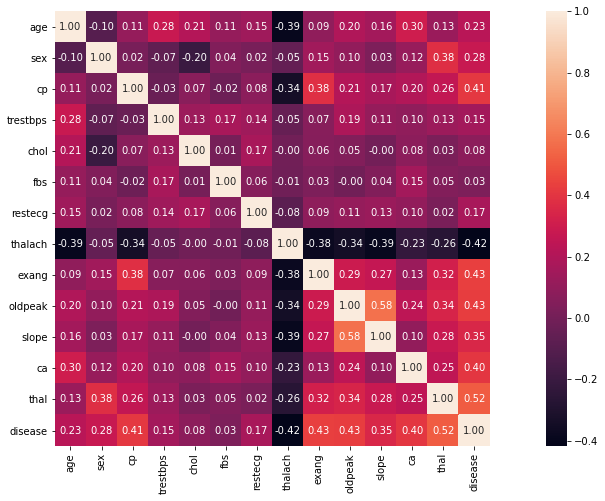

In [236]:
plt.figure(figsize=(20, 8))
sns.heatmap(hdisease.corr(), annot=True, square=True, fmt='0.2f')

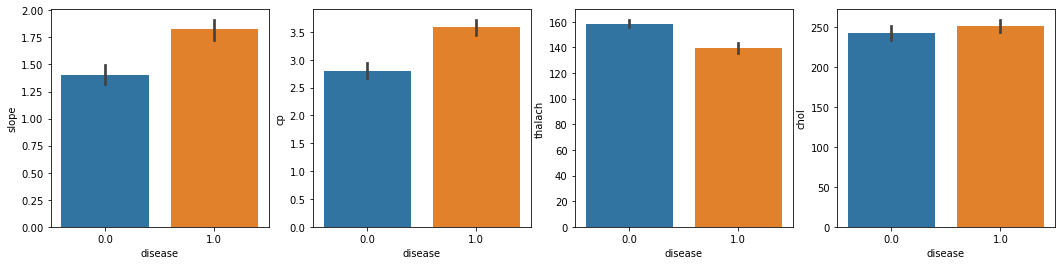

In [237]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))
sns.barplot(x='disease', y='slope', data=hdisease, ax=ax1)
sns.barplot(x='disease', y='cp', data=hdisease, ax=ax2)
sns.barplot(x='disease', y='thalach', data=hdisease, ax=ax3)
sns.barplot(x='disease', y='chol', data=hdisease, ax=ax4)

Most features are highly correlated to the disease feature, it is likely that patient with heart disease have:
- cp: more chest pain
- thalach: surprisingly, they have lower maximum heart rate. After googling, I found that high beats per minute is signal of heart health
- exang: increase pain when exercising
- oldpeak: the ST segment corresponds to the plateau phase of the ventricular transmembrane action potential, patient have a depression in the potential
- cholesterol levels are similar through sick and healthy patient: you can have heart disease without having cholesterol 

In [238]:
hdisease.loc[hdisease['disease'] == 0, 'thalach'].mean()

158.42944785276075

In [239]:
hdisease.loc[hdisease['disease'] == 1, 'thalach'].mean()

139.25899280575538

The slope of the ST segment of sick patient curves more downward than healthy patients.

### Decision Trees
Descision Trees are defined by recursively partitioning the input space into regions. Each region are then partitioned into sub-regions for each child node.
Each leaf node maps the point to a class or regression value depending on the task. Space is sub-divided into non overlapping regions based on some critera at each node. Once created, a tree can be navigated with a new sample of data following each branch with the splits until a final prediction is made.

To understand how to grow a tree, we must introduce the Gini index first.
Assuming that $D$ is the data in a leaf and $N$ the number of samples in $D$, we estimate the class-conditional probability as follow:
$$
    \hat{\pi}_c = \frac{1}{N} \sum_{i \in D}\mathbb{I}(y_i = c)
$$
where $c$ are the classes of the target. The Gini index of a given leaf is:
$$
    G_{l} = \sum_{c=1}^{C}\hat{\pi}_c(1 -\hat{\pi}_c) = 1 - \sum_{c=1}^{C}\hat{\pi}^2_c
$$
To have the Gini index of a split, we compute the Gini index on each of its leaves and sum the indexes weighted by the number of samples in each leaf over the total number of samples to be splitted:
$$
    G_{Node} = \sum_{i=1}^{K} \frac{k_{li}}{U}G_{li}
$$
where $K$ is the number of leaves of the node, $k_{li}$ is the number of samples in the leaf $i^{th}$ leaf and $U$ is the number of sample to be splitted.

In the case of categorical inputs, the most common approach is to consider splits of the form $x_{ij} = c_k$ and $x_{ij} \neq c_k$, for each possible class label $c_k$.<br>
These are the steps for splitting a node:
- If the node is in the maximum depth of the tree, keep it as a leaf.
- For each attribute, we try all the possible thresholds and compute the Gini index of each split. The threshold across all attributes that minimize the Gini index is selected
- A node is said pure if the split generates a empty leaf. If a node is pure, it is set as a leaf.
- If the node has a lowest score than the Gini index of the best split, we keep it as a leaf.
- If separating the data results in an improvement we perform the split.
If the Gini index of a leaf is lower than the Gini index of the potential split at this leaf, we will keep it as a a leaf node.<br>

In [240]:
# Check which data are categorical or not
is_categorical = []
for col in hdisease.columns:
    # If less than 9 unique values, than the feature is categorical
    is_categorical.append(int(len(np.unique(hdisease[col])) < 9))

In [241]:
# Convert data to numpy
data = hdisease.values
# Get unique values of the target
utarget = torch.from_numpy(np.unique(data[:, -1]))

### Split data into train/test

In [242]:
X = data[:, :-1]
y = data[:, -1].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.25)

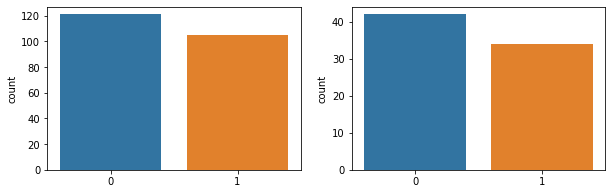

In [243]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(y_train, ax=ax1)
sns.countplot(y_test, ax=ax2)

Selecting a split where both groups have more or less the same percentage of heathy and sick poeple.

In [244]:
# Converting data to PyTorch tensor
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [272]:
def gini(y):
    pi = (y.bincount() / float(y.shape[0]))
    return 1 - pi.pow(2).sum()


class DecisionTreeClassifier():
    def __init__(self, max_depth, is_categorical, columns):
        self.max_depth = max_depth
        self.is_categorical = is_categorical
        self.columns = columns
        self.root = None
    
    def fit(self, X, y, **kwargs):
        if 'max_depth' in kwargs.keys():
            self.max_depth = kwargs['max_depth']
        if 'is_categorical' in kwargs.keys():
            self.is_categorical = kwargs['is_categorical']
        if 'columns' in kwargs.keys():
            self.columns = kwargs['columns']
        self.root = Node(X, y, self.is_categorical, self.max_depth, self.columns, 0)
        
    def predict(self, X):
        if len(X.shape) == 0:
            return 'error: can not predict on empty input.'
        if len(X.shape) == 1:
            return self.root.predict(X)
        
        pred = torch.zeros((X.shape[0],), dtype=torch.int32)
        if self.root == None:
            return 'error: use the fit method before using predict.'
        for i in range(X.shape[0]):
            sample = X[i, :]
            pred[i] = self.root.predict(sample)
        return pred
    
    def get_params(self, deep=False):
        return {'max_depth' : self.max_depth,
                'is_categorical': self.is_categorical,
                'columns': self.columns}
    
    def __str__(self):
        if self.root == None:
            return 'error: use the fit method to print the result of the training.'
        tree_dict = self.root.get_dict()
        pprint(tree_dict)
        return ''

In [273]:
# Base class of a node
class Node():
    def __init__(self, X, y, is_categorical, max_depth, columns, depth=0):
        self.X = X
        self.y = y
        self.size = float(X.shape[0])
        # Prediction if the node will turn into a leaf, or split value
        self.cutoff = None
        # Column to check for splitting the data 
        self.col = None
        # Child nodes
        self.left = None
        self.right = None
        self.categorical = None
        self.depth = depth
        self.columns= columns
        
        # If the node contains only one label, it is set as a leaf
        if self.is_pure() or depth == max_depth or self.X.shape[0] == 1:
            # Select the predominant categorical value and set it as the prediction
            self.make_leaf()
            return
            
        # Computing the gini index on the population before the split
        gini_n = gini(y)
        params = self.find_best_split(is_categorical)
        
        gini_s = params[0]
        # If no improvement, make the node as a leaf
        if gini_s >= gini_n:
            self.make_leaf()
        else:
            self.make_split(params, is_categorical, max_depth)
            
    def is_pure(self):
        return len(self.y.unique()) == 1
    
    def get_label(self):
        return self.y.bincount().argmax().item()
    
    def make_leaf(self):
        self.cutoff = self.get_label()
        self.X = None
        self.y = None
    
    def make_split(self, params, is_categorical, max_depth):
        self.col = params[1]
        self.cutoff = params[2]
        self.categorical = is_categorical[self.col]
        self.left = Node(X=params[3][0],
                         y=params[3][1],
                         is_categorical=is_categorical,
                         max_depth=max_depth,
                         columns=self.columns,
                         depth=self.depth + 1)
        self.right = Node(X=params[4][0],
                          y=params[4][1],
                          is_categorical=is_categorical,
                          max_depth=max_depth,
                          columns=self.columns,
                          depth=self.depth + 1)
        self.X = None
        self.y = None
        self.size = None
    
    def gini_split(self, idx_g_1, idx_g_2, cutoff, feature_idx, best_params):
        g_1 = self.y[idx_g_1].squeeze(1)
        g_2 = self.y[idx_g_2].squeeze(1)
        gini_g1 = gini(g_1) * (float(g_1.shape[0]) / self.size) 
        gini_g2 = gini(g_2) * (float(g_2.shape[0]) / self.size)
        gini_split = (gini_g1 + gini_g2)
        if gini_split < best_params[0]:
            best_params[0] = gini_split.item()
            best_params[1] = feature_idx
            best_params[2] = cutoff.item()
            best_params[3] = [self.X[idx_g_1].squeeze(1), g_1]
            best_params[4] = [self.X[idx_g_2].squeeze(1), g_2]
        return best_params
            
    def find_best_split(self, is_categorical):
        # Create a parameter list that contains:
        # 1: best gini index
        # 2: column index of the best split
        # 3: value of the best split
        # 4: left group [X, y], less than equal to #3 or belongs to the class #3 if categorical
        # 5: right group [X, y], greater than #3 or does not belong to the class #3
        best_params = [2, -1, -1, None, None]
        for i in range(self.X.shape[1]):
            vals = self.X[:, i]
            if is_categorical[i]:
                for cutoff in vals.unique():
                    idx_uv = (vals == cutoff).nonzero()
                    idx_uv_not = (vals != cutoff).nonzero()
                    best_params = self.gini_split(idx_uv, idx_uv_not, cutoff, i, best_params)
            else:
                for cutoff in vals.unique():
                    idx_leq = (vals <= cutoff).nonzero()
                    idx_ge = (vals > cutoff).nonzero()
                    best_params = self.gini_split(idx_leq, idx_ge, cutoff, i, best_params)
        return best_params
    
    def get_dict(self):
        node_dict = {}
        if self.left is None and self.right is None:
            node_dict['pred'] = self.cutoff
        else:
            node_dict['cutoff'] = self.cutoff
            node_dict['feature'] = self.columns[self.col]
            node_dict['categorical'] = self.categorical
            node_dict['left'] = self.left.get_dict()
            node_dict['right'] = self.right.get_dict()
        return node_dict
    
    def predict(self, sample):
        if self.left is None and self.right is None:
            return self.cutoff
        if self.categorical:
            if sample[self.col] == self.cutoff:
                return self.left.predict(sample)
            else:
                return self.right.predict(sample)
        else:
            if sample[self.col] <= self.cutoff:
                return self.left.predict(sample)
            else:
                return self.right.predict(sample)

In [295]:
dt = DecisionTreeClassifier(max_depth=3,
                            is_categorical=is_categorical,
                            columns=hdisease.columns)
dt.fit(X_train, y_train)
print(dt)

{'categorical': 1,
 'cutoff': 3.0,
 'feature': 'thal',
 'left': {'categorical': 1,
          'cutoff': 0.0,
          'feature': 'ca',
          'left': {'categorical': 0,
                   'cutoff': 156.0,
                   'feature': 'trestbps',
                   'left': {'pred': 0},
                   'right': {'pred': 1}},
          'right': {'categorical': 1,
                    'cutoff': 4.0,
                    'feature': 'cp',
                    'left': {'pred': 1},
                    'right': {'pred': 0}}},
 'right': {'categorical': 0,
           'cutoff': 0.6,
           'feature': 'oldpeak',
           'left': {'categorical': 0,
                    'cutoff': 240.0,
                    'feature': 'chol',
                    'left': {'pred': 0},
                    'right': {'pred': 1}},
           'right': {'categorical': 0,
                     'cutoff': 173.0,
                     'feature': 'thalach',
                     'left': {'pred': 1},
                     'rig

We splitted the data using train test split just for printing the tree on some training data.<br>
Using cross validation is a wiser choice to evaluate our model.

### Cross Validation

In [281]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

TypeError: expected np.ndarray (got Tensor)

In [305]:
from sklearn.model_selection import cross_val_score
dt = DecisionTreeClassifier(max_depth=3,
                            is_categorical=is_categorical,
                            columns=hdisease.columns)
fit_params = {
    'max_depth' : 4,
    'is_categorical' : is_categorical,
    'columns' : hdisease.columns
}
test_acc = cross_val_score(dt, X, y, scoring='accuracy', cv=5).mean()
print(test_acc)

0.8110382513661202


### Conclusion
Using cross validation and accuracy as our metric, the best model performed well for a simple model.<br>
Indeed, 81% accuracy on a 5 kfold cross validation is acceptable given the complexity of predicting heart disease.<br>
Looking at the tree structure, the first split is done on the 'thal' feature which has the highest correlation with the target.<br>
The most discriminative features are then 'ca', 'ca' and 'oldpeak' and they are all around 40% correlation with the target.<br>
The model also found lower correlated variable such as 'chol' and 'testbps' of use in the lower nodes.

The 'thal' feature that contributes the most in the decision. It refers to the Thalium stress test result, consisting in injecting radioactive element into the bloodstream of the patient. The thal categorical values refers to the quality of blood circulation. It makes sense that a patient with poor blood circulation is very likely to have a heart disease.

Decision Trees are very prized by the machine learning community for their interpretability and the automatic feature selection.
Unfortunately, the Decision trees tend to overfit so we have to limit the max depth parameter.